In [1]:
# パッケージのimport
import glob
import os
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

print(os.listdir('./images/'))

['.DS_Store', 'rubbish', 'cat', 'dog', '.ipynb_checkpoints']


In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
SEED=1234

In [3]:
class ImageTransform():
    
    def __init__(self,resize, mean, std,degrees=30):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.RandomAffine(degrees=degrees),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

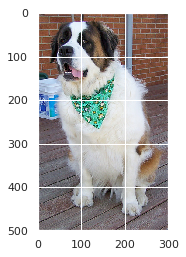

3


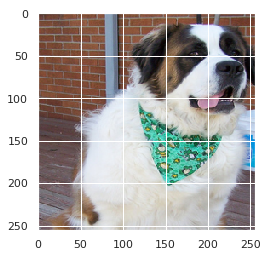

In [4]:
# 画像の読み込み
import cv2

image_file_path = './images/dog/saint_bernard_11.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
print(img_transformed.shape[2])
plt.imshow(img_transformed)
plt.show()

In [5]:
# ファイルパスのリストを作る
def make_datapath_list(name='dog'):
    rootpath = './images/'
    target_path = os.path.join(rootpath+name+'/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

dog_list = make_datapath_list()
dog_list

./images/dog/*.jpg


['./images/dog/german_shorthaired_164.jpg',
 './images/dog/english_setter_137.jpg',
 './images/dog/american_bulldog_41.jpg',
 './images/dog/wheaten_terrier_197.jpg',
 './images/dog/pomeranian_55.jpg',
 './images/dog/great_pyrenees_53.jpg',
 './images/dog/basset_hound_43.jpg',
 './images/dog/samoyed_80.jpg',
 './images/dog/american_bulldog_74.jpg',
 './images/dog/boxer_198.jpg',
 './images/dog/pug_140.jpg',
 './images/dog/samoyed_52.jpg',
 './images/dog/beagle_146.jpg',
 './images/dog/newfoundland_167.jpg',
 './images/dog/english_setter_96.jpg',
 './images/dog/chihuahua_24.jpg',
 './images/dog/wheaten_terrier_92.jpg',
 './images/dog/basset_hound_101.jpg',
 './images/dog/keeshond_40.jpg',
 './images/dog/scottish_terrier_71.jpg',
 './images/dog/wheaten_terrier_135.jpg',
 './images/dog/boxer_46.jpg',
 './images/dog/yorkshire_terrier_161.jpg',
 './images/dog/pug_33.jpg',
 './images/dog/great_pyrenees_66.jpg',
 './images/dog/wheaten_terrier_100.jpg',
 './images/dog/chihuahua_25.jpg',
 './ima

In [6]:
dog_names = []
for file in dog_list:
    name = file.split('/')[3].split('_')[0]
    dog_names.append(name)

dog_names = set(dog_names)
print(dog_names)
class_num = len(dog_names)

{'keeshond', 'samoyed', 'miniature', 'chihuahua', 'yorkshire', 'great', 'newfoundland', 'leonberger', 'pomeranian', 'german', 'american', 'basset', 'japanese', 'shiba', 'havanese', 'saint', 'wheaten', 'staffordshire', 'pug', 'english', 'boxer', 'scottish', 'beagle'}


In [7]:
labels = []
for file in dog_list:
    if 'keeshond' in file:
        labels.append(0)
    elif 'great' in file:
        labels.append(1)
    elif 'wheaten' in file:
        labels.append(2)
    elif 'american' in file:
        labels.append(3)
    elif 'saint' in file:
        labels.append(4)
    elif 'english' in file:
        labels.append(5)
    elif 'japanese' in file:
        labels.append(6)
    elif 'chihuahua' in file:
        labels.append(7)
    elif 'german' in file:
        labels.append(8)
    elif 'scottish' in file:
        labels.append(9)
    elif 'miniature' in file:
        labels.append(10)
    elif 'pomeranian' in file:
        labels.append(11)
    elif 'leonberger' in file:
        labels.append(12)
    elif 'shiba' in file:
        labels.append(13)
    elif 'samoyed' in file:
        labels.append(14)
    elif 'boxer' in file:
        labels.append(15)
    elif 'havanese' in file:
        labels.append(16)
    elif 'yorkshire' in file:
        labels.append(17)
    elif 'beagle' in file:
        labels.append(18)
    elif 'basset' in file:
        labels.append(19)
    elif 'newfoundland' in file:
        labels.append(20)
    elif 'pug' in file:
        labels.append(21)
    elif 'staffordshire' in file:
        labels.append(22)

In [8]:
print(len(dog_list))
print(len(labels))

4988
4988


### Dataset作成

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dog_list, labels, stratify=labels, random_state=SEED, shuffle=True,test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=SEED, shuffle=True,test_size=0.1)
print('X_train : ',len(X_train))
print('X_val : ',len(X_val))
print('X_test : ',len(X_test))
print('y_train : ',len(y_train))
print('y_val : ',len(y_val))
print('y_test : ',len(y_test))

X_train :  4040
X_val :  449
X_test :  499
y_train :  4040
y_val :  449
y_test :  499


In [10]:
class dogDataset(data.Dataset):
    def __init__(self, file_list, label, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        self.label = label
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img, phase=self.phase)
        
        #ラベル
        label = self.label[index]
        
        #print(img_path)
        #print(img_transformed.size())
        
        return img_transformed, label

In [11]:
train_dataset = dogDataset(file_list=X_train, label=y_train, 
                          transform=ImageTransform(size, mean, std),
                          phase='train')
val_dataset = dogDataset(file_list=X_val, label=y_val,
                        transform=ImageTransform(size, mean, std),
                        phase='val')
test_dataset = dogDataset(file_list=X_test, label=y_test,
                        transform=ImageTransform(size, mean, std),
                        phase='val')

In [12]:
# 動作確認
index=10
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
19


### DataLoaderを作成

In [13]:
batch_size=32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# 辞書型に
dataloaders_dict = {'train':train_dataloader,
                    'val':val_dataloader,
                    'test':test_dataloader}

In [14]:
# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 256, 256])
tensor([21,  5,  7, 12,  2, 22, 16, 10, 17, 21, 20,  8, 21, 22, 12,  4,  3, 18,
        19, 21, 13,  9, 19,  6,  6, 20,  0,  0,  7,  2, 12,  2])


### ネットワークモデルの作成

In [15]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# VGGの最後の層を付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=class_num)


# 訓練モード
net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [16]:
# 損失関数
criterion = nn.CrossEntropyLoss()

In [17]:
# 最適化手法
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないようにする
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
        
    else:
        param.requeres_grad = False
        
print('-'*10)
print(params_to_update)

classifier.6.weight
classifier.6.bias
----------
[Parameter containing:
tensor([[ 0.0095, -0.0016,  0.0085,  ...,  0.0035, -0.0058,  0.0051],
        [ 0.0114,  0.0139, -0.0093,  ..., -0.0109, -0.0131,  0.0025],
        [-0.0137, -0.0036, -0.0133,  ...,  0.0139, -0.0082,  0.0070],
        ...,
        [-0.0129,  0.0119, -0.0010,  ...,  0.0059, -0.0148,  0.0087],
        [-0.0137,  0.0048,  0.0074,  ..., -0.0065, -0.0004,  0.0009],
        [ 0.0015,  0.0107,  0.0073,  ..., -0.0003,  0.0020,  0.0027]],
       requires_grad=True), Parameter containing:
tensor([-0.0073, -0.0122, -0.0121,  0.0008,  0.0081, -0.0117,  0.0134, -0.0100,
        -0.0058,  0.0111,  0.0082, -0.0009,  0.0139, -0.0139, -0.0077, -0.0132,
         0.0090, -0.0025,  0.0045,  0.0014, -0.0091, -0.0120,  0.0039],
       requires_grad=True)]


In [18]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [19]:
# モデルを学習させる関数を作成
import pandas as pd
from time import time

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 初期設定
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス',device)
    
    # ネットワークをGPUへ
    net.to(device)
    
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        start_time = time()

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                epoch_train_loss = 0.0  # epochの損失和
                epoch_train_corrects = 0  # epochの正解数
            else:
                net.eval()   # モデルを検証モードに
                epoch_val_loss = 0.0  # epochの損失和
                epoch_val_corrects = 0  # epochの正解数      

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                epoch_train_acc=0.0
                epoch_train_loss = np.inf
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                # GPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    if phase == 'train':
                        epoch_train_loss += loss.item() * inputs.size(0)  
                        # 正解数の合計を更新
                        epoch_train_corrects += torch.sum(preds == labels.data)
                        
                    elif phase=='val':
                        epoch_val_loss += loss.item() * inputs.size(0)  
                        # 正解数の合計を更新
                        epoch_val_corrects += torch.sum(preds == labels.data)
            
            if phase=='train':
                # epochごとのlossと正解率を表示
                epoch_train_loss = epoch_train_loss / len(dataloaders_dict[phase].dataset)
                epoch_train_acc = epoch_train_corrects.double() / len(dataloaders_dict[phase].dataset)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_train_loss, epoch_train_acc))
                
            elif phase=='val':
                # epochごとのlossと正解率を表示
                epoch_val_loss = epoch_val_loss / len(dataloaders_dict[phase].dataset)
                epoch_val_acc = epoch_val_corrects.double() / len(dataloaders_dict[phase].dataset)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_val_loss, epoch_val_acc))
                
            
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss,
                     'train_acc': float(epoch_train_acc), 'val_acc':float(epoch_val_acc)}
        logs.append(log_epoch)
        print('finish time : ', time()-start_time)
    df = pd.DataFrame(logs)
    log_dir_path = './log'
    if not os.path.exists(log_dir_path):
        os.mkdir(log_dir_path)
    df.to_csv(log_dir_path+"/dog_log.csv")
    weight_dir_path = './weights'
    if not os.path.exists(weight_dir_path):
        os.mkdir(weight_dir_path)
    torch.save(net.state_dict(), weight_dir_path+'/dog_vgg.pth')

In [20]:
# 学習・検証を実行する
num_epochs=100

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス cuda:0


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/100
-------------


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 3.1383 Acc: 0.0512
finish time :  7.810235977172852
Epoch 2/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 1.2881 Acc: 0.6656


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.6015 Acc: 0.8441
finish time :  64.28921508789062
Epoch 3/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.6268 Acc: 0.8238


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4790 Acc: 0.8641
finish time :  54.36241888999939
Epoch 4/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.5391 Acc: 0.8448


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4523 Acc: 0.8664
finish time :  54.33421993255615
Epoch 5/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4971 Acc: 0.8530


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4251 Acc: 0.8864
finish time :  54.792468547821045
Epoch 6/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4583 Acc: 0.8554


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4403 Acc: 0.8530
finish time :  54.333922147750854
Epoch 7/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4442 Acc: 0.8582


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4032 Acc: 0.8686
finish time :  54.55879998207092
Epoch 8/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4194 Acc: 0.8693


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3937 Acc: 0.8775
finish time :  54.553741216659546
Epoch 9/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4195 Acc: 0.8668


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3926 Acc: 0.8842
finish time :  54.721840620040894
Epoch 10/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.4107 Acc: 0.8696


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3958 Acc: 0.8686
finish time :  54.442522287368774
Epoch 11/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3937 Acc: 0.8713


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3975 Acc: 0.8842
finish time :  54.65829300880432
Epoch 12/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3825 Acc: 0.8780


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3838 Acc: 0.8797
finish time :  54.48059701919556
Epoch 13/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3753 Acc: 0.8762


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3774 Acc: 0.8864
finish time :  54.441649198532104
Epoch 14/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3713 Acc: 0.8802


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3820 Acc: 0.8797
finish time :  54.50456619262695
Epoch 15/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3672 Acc: 0.8802


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3786 Acc: 0.8797
finish time :  54.67482399940491
Epoch 16/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3558 Acc: 0.8869


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3719 Acc: 0.8864
finish time :  54.571189403533936
Epoch 17/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3469 Acc: 0.8871


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3747 Acc: 0.8842
finish time :  54.8844096660614
Epoch 18/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3500 Acc: 0.8824


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3671 Acc: 0.8797
finish time :  54.7299861907959
Epoch 19/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3446 Acc: 0.8896


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3690 Acc: 0.8886
finish time :  54.661229848861694
Epoch 20/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3375 Acc: 0.8891


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3663 Acc: 0.8842
finish time :  54.62649607658386
Epoch 21/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3424 Acc: 0.8903


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3725 Acc: 0.8775
finish time :  54.54975986480713
Epoch 22/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3433 Acc: 0.8861


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3644 Acc: 0.8797
finish time :  54.54013752937317
Epoch 23/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3266 Acc: 0.8906


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3665 Acc: 0.8820
finish time :  54.52307415008545
Epoch 24/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3230 Acc: 0.8941


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3632 Acc: 0.8909
finish time :  54.58963227272034
Epoch 25/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3137 Acc: 0.8926


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3570 Acc: 0.8886
finish time :  54.754677295684814
Epoch 26/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3190 Acc: 0.8933


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3631 Acc: 0.8886
finish time :  54.71850776672363
Epoch 27/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3040 Acc: 0.9042


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3696 Acc: 0.8842
finish time :  54.515909910202026
Epoch 28/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3216 Acc: 0.8906


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3586 Acc: 0.8953
finish time :  54.42434477806091
Epoch 29/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3045 Acc: 0.9005


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3658 Acc: 0.8820
finish time :  54.308088064193726
Epoch 30/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3053 Acc: 0.9002


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3621 Acc: 0.8931
finish time :  54.60680866241455
Epoch 31/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3143 Acc: 0.8946


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3563 Acc: 0.8953
finish time :  54.78046250343323
Epoch 32/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3070 Acc: 0.8950


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3517 Acc: 0.8931
finish time :  54.508524656295776
Epoch 33/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3074 Acc: 0.9002


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3581 Acc: 0.8886
finish time :  54.49006462097168
Epoch 34/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2998 Acc: 0.8978


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3683 Acc: 0.8842
finish time :  54.38688373565674
Epoch 35/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3023 Acc: 0.8978


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3583 Acc: 0.8931
finish time :  54.57801413536072
Epoch 36/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2993 Acc: 0.9032


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3655 Acc: 0.8820
finish time :  54.659340143203735
Epoch 37/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2928 Acc: 0.8973


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3600 Acc: 0.8976
finish time :  54.574679136276245
Epoch 38/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2981 Acc: 0.8955


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3545 Acc: 0.8976
finish time :  54.493292570114136
Epoch 39/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2968 Acc: 0.8985


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3514 Acc: 0.8931
finish time :  54.81210923194885
Epoch 40/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2709 Acc: 0.9129


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3572 Acc: 0.8976
finish time :  55.09906244277954
Epoch 41/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2829 Acc: 0.9089


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3609 Acc: 0.8909
finish time :  54.5974063873291
Epoch 42/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2739 Acc: 0.9074


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3601 Acc: 0.8976
finish time :  54.595014333724976
Epoch 43/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2942 Acc: 0.8963


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3567 Acc: 0.8931
finish time :  54.47423601150513
Epoch 44/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2719 Acc: 0.9064


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3652 Acc: 0.8797
finish time :  54.72647309303284
Epoch 45/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2779 Acc: 0.9094


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3474 Acc: 0.8998
finish time :  54.88560390472412
Epoch 46/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2764 Acc: 0.9079


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3501 Acc: 0.8953
finish time :  54.47954297065735
Epoch 47/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2676 Acc: 0.9077


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3414 Acc: 0.8976
finish time :  54.372485876083374
Epoch 48/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2712 Acc: 0.9064


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3538 Acc: 0.8953
finish time :  54.827266216278076
Epoch 49/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2710 Acc: 0.9064


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3662 Acc: 0.8886
finish time :  54.63637328147888
Epoch 50/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2706 Acc: 0.9101


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3554 Acc: 0.8797
finish time :  54.98103642463684
Epoch 51/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2613 Acc: 0.9109


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3507 Acc: 0.9020
finish time :  54.602909564971924
Epoch 52/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2718 Acc: 0.9092


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3523 Acc: 0.8976
finish time :  54.56703209877014
Epoch 53/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2732 Acc: 0.9069


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3429 Acc: 0.8976
finish time :  54.43026280403137
Epoch 54/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2709 Acc: 0.9146


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3462 Acc: 0.8976
finish time :  54.411123514175415
Epoch 55/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2779 Acc: 0.9067


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3510 Acc: 0.8931
finish time :  54.38522124290466
Epoch 56/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2640 Acc: 0.9104


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3458 Acc: 0.8931
finish time :  54.52315068244934
Epoch 57/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2569 Acc: 0.9124


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3470 Acc: 0.8864
finish time :  54.452319622039795
Epoch 58/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2678 Acc: 0.9062


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3557 Acc: 0.8909
finish time :  54.79997539520264
Epoch 59/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2600 Acc: 0.9099


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3540 Acc: 0.8931
finish time :  54.912747621536255
Epoch 60/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2574 Acc: 0.9094


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3516 Acc: 0.8953
finish time :  54.63016963005066
Epoch 61/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2739 Acc: 0.9047


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3492 Acc: 0.8820
finish time :  54.728721380233765
Epoch 62/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2514 Acc: 0.9146


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3480 Acc: 0.9020
finish time :  54.6847939491272
Epoch 63/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2534 Acc: 0.9109


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3523 Acc: 0.8931
finish time :  54.6045286655426
Epoch 64/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2507 Acc: 0.9136


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3564 Acc: 0.8909
finish time :  54.93531632423401
Epoch 65/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2569 Acc: 0.9116


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3516 Acc: 0.8886
finish time :  55.05185294151306
Epoch 66/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2621 Acc: 0.9129


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3567 Acc: 0.8953
finish time :  54.478660345077515
Epoch 67/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2581 Acc: 0.9129


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3518 Acc: 0.8909
finish time :  54.301881551742554
Epoch 68/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2539 Acc: 0.9126


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3542 Acc: 0.8953
finish time :  54.440807580947876
Epoch 69/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2483 Acc: 0.9163


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3605 Acc: 0.8820
finish time :  54.391125440597534
Epoch 70/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2543 Acc: 0.9121


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3554 Acc: 0.8909
finish time :  54.656432151794434
Epoch 71/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2442 Acc: 0.9158


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3514 Acc: 0.8931
finish time :  54.578710079193115
Epoch 72/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2595 Acc: 0.9119


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3605 Acc: 0.8820
finish time :  54.85581612586975
Epoch 73/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2522 Acc: 0.9146


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3415 Acc: 0.8909
finish time :  54.465211391448975
Epoch 74/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2413 Acc: 0.9181


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3462 Acc: 0.8886
finish time :  55.00895142555237
Epoch 75/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2374 Acc: 0.9181


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3414 Acc: 0.8864
finish time :  54.817381143569946
Epoch 76/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2351 Acc: 0.9203


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3554 Acc: 0.8864
finish time :  54.985153675079346
Epoch 77/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2270 Acc: 0.9235


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3468 Acc: 0.9020
finish time :  55.07360243797302
Epoch 78/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2344 Acc: 0.9228


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3551 Acc: 0.8864
finish time :  54.922794818878174
Epoch 79/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2478 Acc: 0.9156


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3431 Acc: 0.8976
finish time :  54.777631521224976
Epoch 80/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2450 Acc: 0.9156


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3499 Acc: 0.8886
finish time :  54.64665460586548
Epoch 81/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2237 Acc: 0.9200


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3466 Acc: 0.8953
finish time :  55.232178688049316
Epoch 82/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2380 Acc: 0.9196


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3428 Acc: 0.8976
finish time :  54.912832736968994
Epoch 83/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2345 Acc: 0.9228


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3489 Acc: 0.8953
finish time :  54.58361768722534
Epoch 84/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2301 Acc: 0.9205


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3475 Acc: 0.9042
finish time :  54.56916046142578
Epoch 85/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2196 Acc: 0.9265


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3507 Acc: 0.8909
finish time :  54.52616310119629
Epoch 86/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2353 Acc: 0.9193


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3795 Acc: 0.8753
finish time :  54.41370463371277
Epoch 87/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2319 Acc: 0.9188


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3482 Acc: 0.8842
finish time :  54.90342330932617
Epoch 88/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2178 Acc: 0.9272


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3545 Acc: 0.8953
finish time :  55.470786809921265
Epoch 89/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2375 Acc: 0.9166


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3541 Acc: 0.8820
finish time :  54.962493896484375
Epoch 90/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2296 Acc: 0.9225


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3519 Acc: 0.8909
finish time :  54.393532276153564
Epoch 91/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2168 Acc: 0.9270


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3465 Acc: 0.8886
finish time :  54.379300355911255
Epoch 92/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2395 Acc: 0.9153


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3641 Acc: 0.8753
finish time :  55.0592622756958
Epoch 93/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2262 Acc: 0.9230


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3457 Acc: 0.8886
finish time :  54.596747398376465
Epoch 94/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2293 Acc: 0.9218


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3628 Acc: 0.8931
finish time :  54.36671280860901
Epoch 95/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2333 Acc: 0.9228


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3495 Acc: 0.8931
finish time :  54.7135694026947
Epoch 96/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2304 Acc: 0.9200


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3461 Acc: 0.8976
finish time :  54.99383997917175
Epoch 97/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2288 Acc: 0.9225


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3504 Acc: 0.8909
finish time :  54.89646244049072
Epoch 98/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2229 Acc: 0.9230


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3498 Acc: 0.8886
finish time :  54.626789808273315
Epoch 99/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2332 Acc: 0.9235


  0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3441 Acc: 0.9020
finish time :  54.45051860809326
Epoch 100/100
-------------


  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2201 Acc: 0.9252


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


val Loss: 0.3695 Acc: 0.8731
finish time :  54.57505822181702


In [21]:
df = pd.read_csv('./log/dog_log.csv')
df.head()

,Unnamed: 0,epoch,train_acc,train_loss,val_acc,val_loss
0,0,1,0.000000,inf,0.051225,3.138273
1,1,2,0.665594,1.288135,0.844098,0.601533
2,2,3,0.823762,0.626835,0.864143,0.478963
3,3,4,0.844802,0.539057,0.866370,0.452263
4,4,5,0.852970,0.497100,0.886414,0.425132


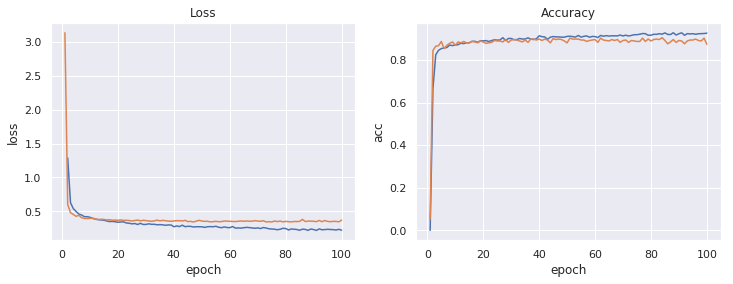

In [22]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

axL.plot(df.epoch, df.train_loss, label='train')
axL.plot(df.epoch, df.val_loss, label='val')
axL.set_title('Loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.grid(True)

axR.plot(df.epoch, df.train_acc, label='train')
axR.plot(df.epoch, df.val_acc, label='val')
axR.set_title('Accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('acc')
axR.grid(True)

fig.show()

In [23]:
# #PyTorchのネットワークパラメータのロード
load_path = './weights/dog_vgg.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

## CPU上で重みをロードする場合
#load_weights = torch.load(load_path, map_location={'cuda:0':'cpu'})
#net.load_state_dict(load_weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [24]:
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス',device)
# ネットワークをGPUへ
net.to(device)

for i, (inputs, labels) in enumerate(tqdm(dataloaders_dict['test'])):

    # GPUにデータを送る
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    ## 予測
    
    pred = net(inputs)
    ## softmaxにかけた後、確率最大を取り出す
    softmax = torch.nn.Softmax(dim=1)
    pred = torch.argmax(softmax(pred),dim=1)
    
    if i ==0:
        predict = pred
        true = labels
    else:
        predict = torch.cat((predict, pred),dim=0)
        true = torch.cat((true,labels),dim=0)
    

  0%|          | 0/16 [00:00<?, ?it/s]

使用デバイス cuda:0


100%|██████████| 16/16 [00:06<00:00,  1.13it/s]


0.9298597194388778
[[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  2]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 20  

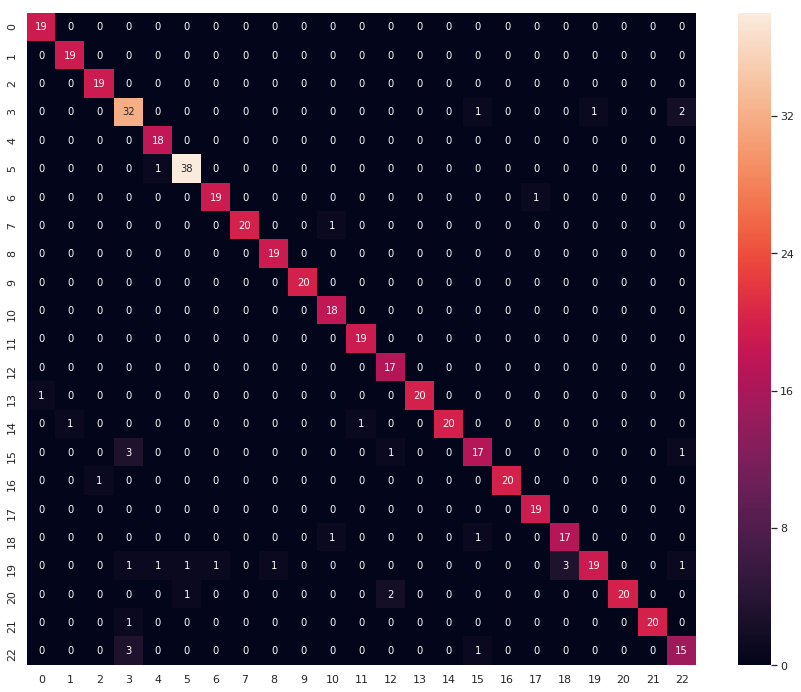

In [26]:
cm = confusion_matrix(predict.cpu(), true.cpu())
print(accuracy_score(predict.cpu(),true.cpu()))
print(cm)

plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True)